# Simple Neural Network Model with different inputs

Input: testing different inputs

Output: optimal max-shape portfolio with normal restrictions for the next period

## Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.regularizers import L2

from helper_functions import train_and_evaluate_model

In [3]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [4]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()

In [5]:
days_to_recalculate = data_provider.get_days_to_recalculate()

# Start after 1 year to have enough historic data for first calculated period
days_to_recalculate = days_to_recalculate.iloc[12:]
days_to_recalculate = pd.DatetimeIndex(days_to_recalculate)
days_to_recalculate

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
               '2023-11-03', '2023-12-05'],
              dtype='datetime64[ns]', name='Days to rebalance', length=288, freq=None)

Preparing outputs common for all models

In [6]:
os.chdir(os.path.expanduser('../optimization'))

from PortfolioOptimizer import PortfolioOptimizer

In [7]:
y = []
for i in range(0,len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    optimizer = PortfolioOptimizer()
    w, constraints = optimizer.get_normal_constraints(acwi_weights_year)
    optimal_portfolio = optimizer.get_optimal_portfolio(
        data_period, w, constraints)
    y.append(optimal_portfolio.values)

y = np.array(y)
y.shape

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(288, 27)

In [8]:
val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])

# Train
dates_for_training = days_to_recalculate[:val_split]
y_train = y[:val_split]

# Validation
dates_for_validation = days_to_recalculate[val_split:test_split]
y_val = y[val_split:test_split]

# Test
dates_for_test = days_to_recalculate[test_split:]
y_test = y[test_split:]

In [9]:
os.chdir(os.path.expanduser('../data'))

## Defining models for different inputs

### DNN Model with a single fixed weight composite indicators

In [10]:
x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_simple_composite_indicator(
        date, periods=6)
    x.append(indicators.values)

x_simple_composite_indicator = np.array(x)

x_train_simple_composite_indicator = x_simple_composite_indicator[:val_split]
x_val_simple_composite_indicator = x_simple_composite_indicator[val_split:test_split]
x_test_simple_composite_indicator = x_simple_composite_indicator[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8502 - val_loss: 2.6101 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5349 - val_loss: 2.3155 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2470 - val_loss: 2.0482 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9861 - val_loss: 1.8074 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7517 - val_loss: 1.5916 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5414 - val_loss: 1.3991 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3543 - val_loss: 1.2279 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1878 - val_loss: 1.0759 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0402 - val_loss: 0.9413 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

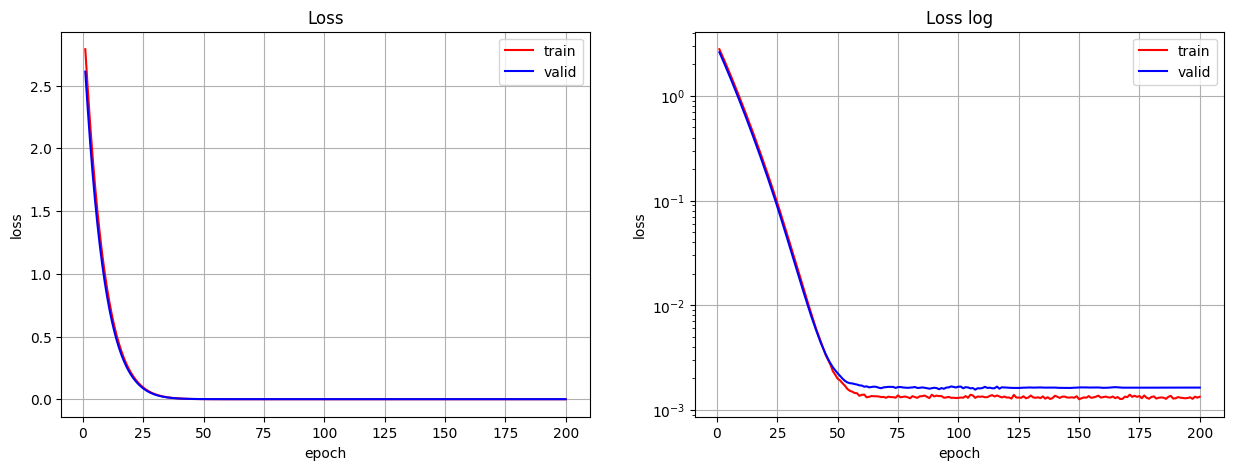

In [11]:
model_dnn_simple_composite_indicator = Sequential((
    Flatten(input_shape=x_train_simple_composite_indicator.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_simple_composite_indicator, 
                         x_train_simple_composite_indicator, y_train,
                         x_val_simple_composite_indicator, y_val, 
                         x_test_simple_composite_indicator, y_test)

### DNN Model with a single Manufacturing PMI indicator

In [12]:
indicator = 'Manufacturing PMI'
x = []
for date in days_to_recalculate:
    df = data_provider.get_key_indicator_values(indicator)
    df_normalized = data_provider.normilize_dataframe(df)
    df_last_values = data_provider.get_latest_data(
        indicator, df_normalized, date, periods=6)
    x.append(df_last_values.values)

x_manufacturing_pmi = np.array(x)

x_train_manufacturing_pmi = x_manufacturing_pmi[:val_split]
x_val_manufacturing_pmi = x_manufacturing_pmi[val_split:test_split]
x_test_manufacturing_pmi = x_manufacturing_pmi[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6987 - val_loss: 2.4666 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3951 - val_loss: 2.1839 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1183 - val_loss: 1.9281 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8691 - val_loss: 1.6982 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6449 - val_loss: 1.4927 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4446 - val_loss: 1.3096 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2671 - val_loss: 1.1471 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1092 - val_loss: 1.0031 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9689 - val_loss: 0.8757 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

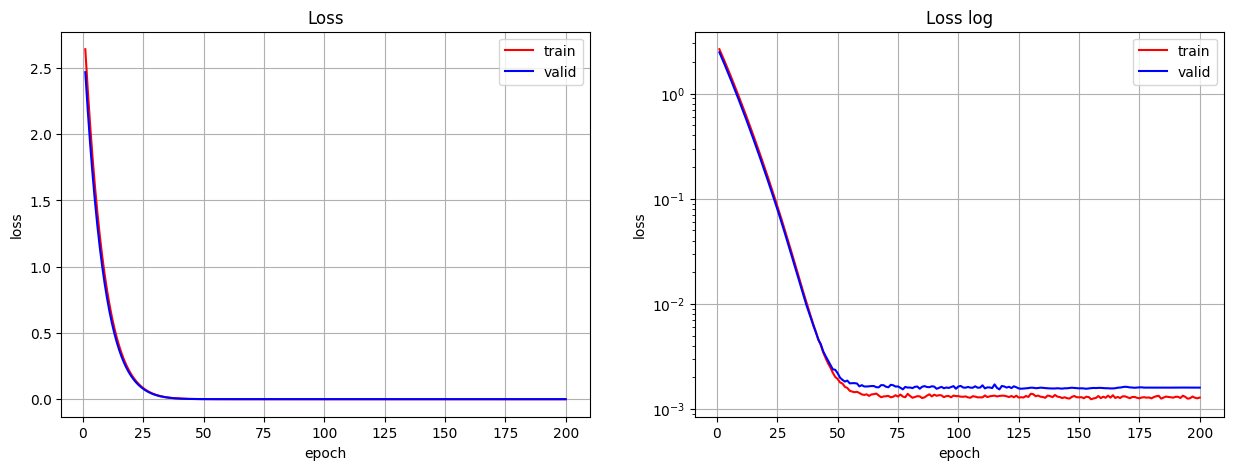

In [13]:
model_dnn_manufacturing_pmi = Sequential((
    Flatten(input_shape=x_train_manufacturing_pmi.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_manufacturing_pmi, 
                         x_train_manufacturing_pmi, y_train,
                         x_val_manufacturing_pmi, y_val, 
                         x_test_manufacturing_pmi, y_test)

### DNN Model with 6 separate indicators

In [14]:
x = []
for date in days_to_recalculate:
    indicators_arr = []
    for indicator in data_provider.key_indicators:
        df = data_provider.get_key_indicator_values(indicator)
        df_normalized = data_provider.normilize_dataframe(df)
        indicators_arr.append(data_provider.get_latest_data(
            indicator, df_normalized, date, periods=6).values)

    concat_indicators = np.concatenate(indicators_arr, axis=1)
    x.append(concat_indicators)

x_separate_indicators = np.array(x)

x_train_separate_indicators = x_separate_indicators[:val_split]
x_val_separate_indicators = x_separate_indicators[val_split:test_split]
x_test_separate_indicators = x_separate_indicators[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 972)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │        15,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,027 (62.61 KB)

 Trainable params: 16,027 (62.61 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.9689 - val_loss: 2.3931 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2319 - val_loss: 1.7702 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6430 - val_loss: 1.2837 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1855 - val_loss: 0.9139 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8404 - val_loss: 0.6394 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5853 - val_loss: 0.4400 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4008 - val_loss: 0.2981 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2698 - val_loss: 0.1990 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1794 - val_loss: 0.1312 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

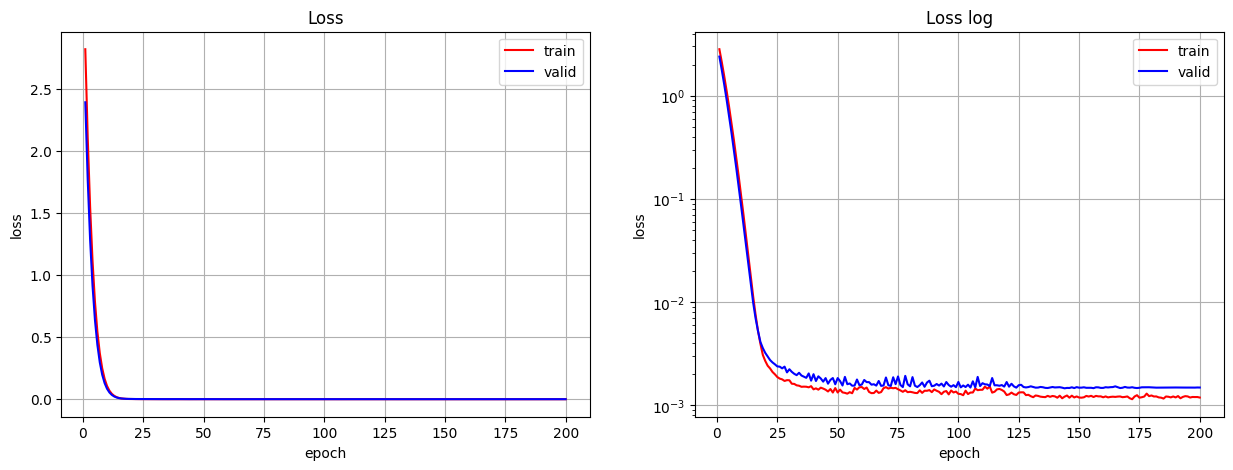

In [15]:
model_dnn_separate_indicators = Sequential((
    Flatten(input_shape=x_train_separate_indicators.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_separate_indicators, 
                         x_train_separate_indicators, y_train,
                         x_val_separate_indicators, y_val, 
                         x_test_separate_indicators, y_test)

### DNN Model with 15 separate indicators

In [16]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators_arr = []
    for indicator in all_indicators:
        df = data_provider.get_key_indicator_values(indicator)
        df_normalized = data_provider.normilize_dataframe(df)
        indicators_arr.append(data_provider.get_latest_data(
            indicator, df_normalized, date, periods=6).values)

    concat_indicators = np.concatenate(indicators_arr, axis=1)
    x.append(concat_indicators)

x_separate_all_indicators = np.array(x)

x_train_separate_all_indicators = x_separate_all_indicators[:val_split]
x_val_separate_all_indicators = x_separate_all_indicators[val_split:test_split]
x_test_separate_all_indicators = x_separate_all_indicators[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 2430)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │        38,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,355 (153.73 KB)

 Trainable params: 39,355 (153.73 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8693 - val_loss: 2.0170 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8002 - val_loss: 1.2088 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0643 - val_loss: 0.6815 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5908 - val_loss: 0.3606 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3064 - val_loss: 0.1778 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1478 - val_loss: 0.0815 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0663 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0282 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

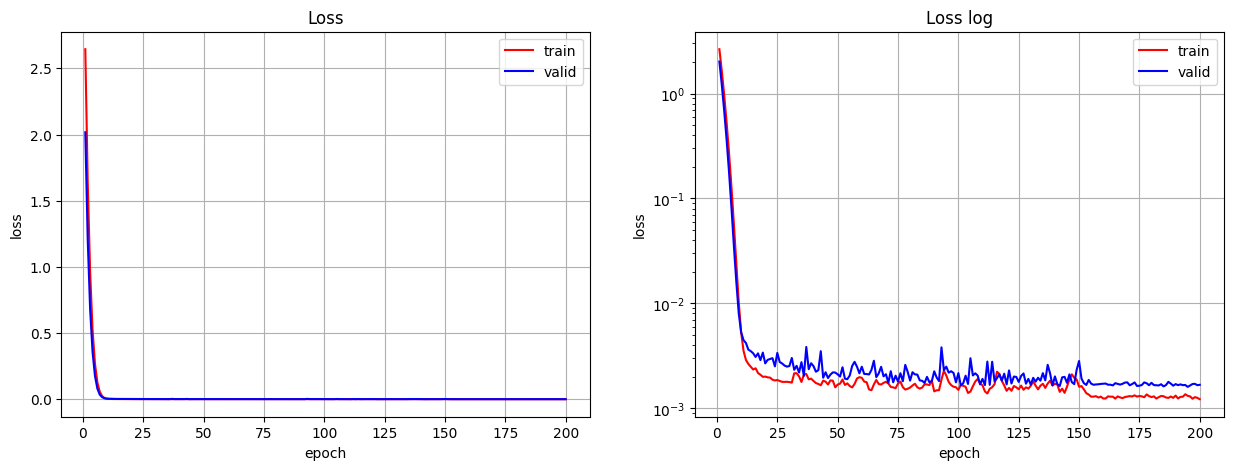

In [17]:
model_dnn_separate_all_indicators = Sequential((
    Flatten(input_shape=x_train_separate_all_indicators.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_separate_all_indicators, 
                         x_train_separate_all_indicators, y_train,
                         x_val_separate_all_indicators, y_val, 
                         x_test_separate_all_indicators, y_test)

### DNN Model with single principal component from PCA

In [18]:
x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=data_provider.key_indicators)
    x.append(indicators.values)

x_pca_component = np.array(x)

x_train_pca_component = x_pca_component[:val_split]
x_val_pca_component = x_pca_component[val_split:test_split]
x_test_pca_component = x_pca_component[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8328 - val_loss: 2.5936 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5194 - val_loss: 2.3008 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2329 - val_loss: 2.0350 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9738 - val_loss: 1.7956 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7405 - val_loss: 1.5812 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5316 - val_loss: 1.3898 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3459 - val_loss: 1.2196 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1806 - val_loss: 1.0686 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0338 - val_loss: 0.9347 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

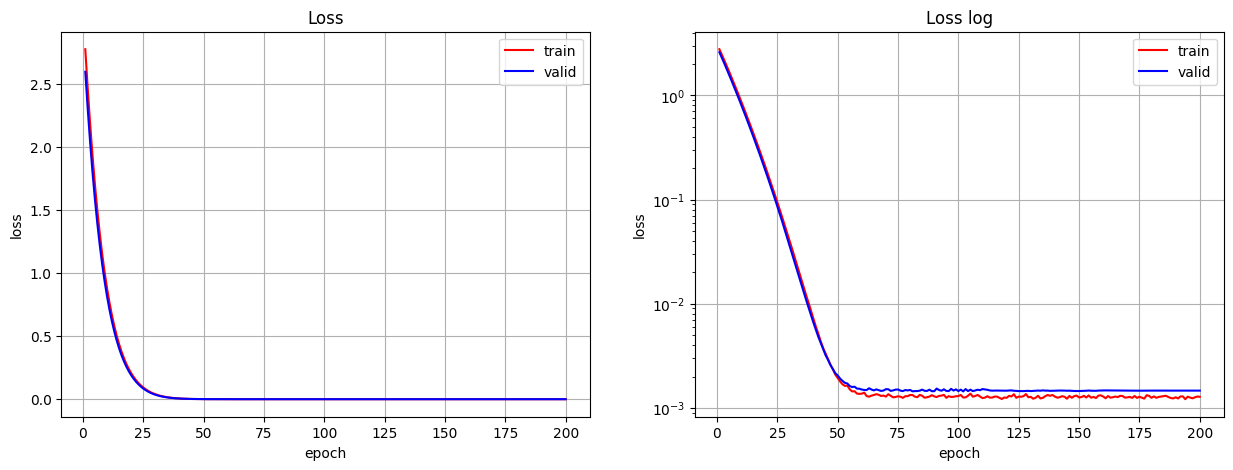

In [19]:
model_dnn_pca_component = Sequential((
    Flatten(input_shape=x_train_pca_component.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_pca_component, 
                         x_train_pca_component, y_train,
                         x_val_pca_component, y_val, 
                         x_test_pca_component, y_test)

### DNN Model with single principal component from PCA for all 15 indicators

In [20]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators)
    x.append(indicators.values)

x_pca_component_all = np.array(x)

x_train_pca_component_all = x_pca_component_all[:val_split]
x_val_pca_component_all = x_pca_component_all[val_split:test_split]
x_test_pca_component_all = x_pca_component_all[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8509 - val_loss: 2.6089 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5353 - val_loss: 2.3145 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2475 - val_loss: 2.0473 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9867 - val_loss: 1.8065 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7522 - val_loss: 1.5907 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5424 - val_loss: 1.3981 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3546 - val_loss: 1.2268 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1883 - val_loss: 1.0746 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0404 - val_loss: 0.9398 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

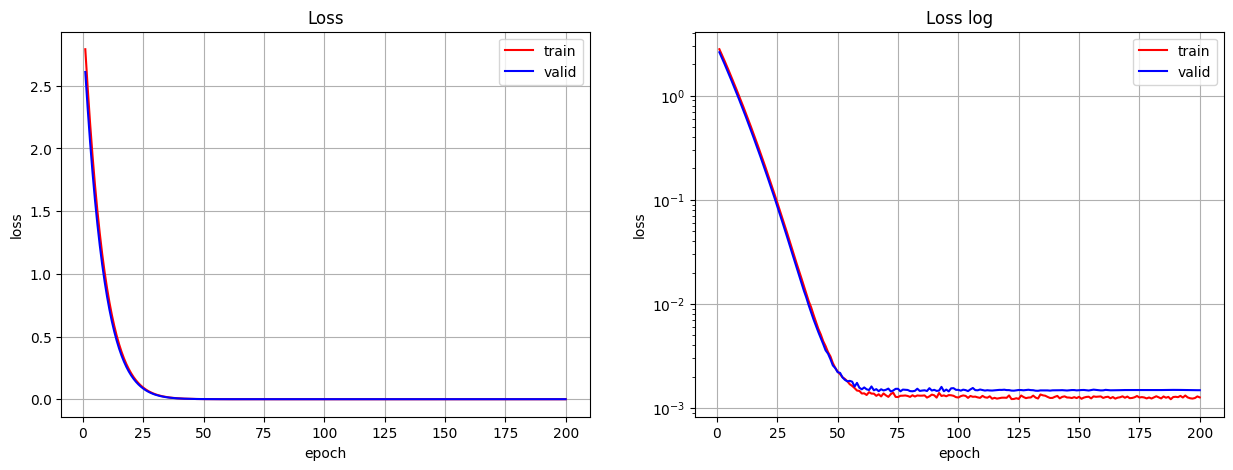

In [21]:
model_dnn_pca_component_all = Sequential((
    Flatten(input_shape=x_train_pca_component_all.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_pca_component_all, 
                         x_train_pca_component_all, y_train,
                         x_val_pca_component_all, y_val, 
                         x_test_pca_component_all, y_test)

### DNN Model with 2 principal components from PCA for all 15 indicators

In [22]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators
indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators, n_components=2)
indicators

,United States,Japan,United Kingdom,Canada,France,Switzerland,Germany,Australia,Netherlands,Sweden,...,Norway,China,Taiwan,India,Korea,Brazil,Russia,South Africa,Mexico,Malaysia
0,0.573364,-0.272276,-0.462516,-0.609284,0.288486,0.383075,0.381226,-0.095530,0.516556,0.752452,...,-0.101579,-0.995422,2.145156,0.026774,-1.313208,0.253228,0.776003,0.422122,0.425620,-0.677187
1,-0.092734,-2.935052,-0.270103,-0.334563,0.720700,0.069055,-0.240348,-3.180448,1.049208,-0.744203,...,2.017018,-0.377660,0.005063,-1.661586,5.504464,3.957579,2.089029,-2.912446,-0.227852,-0.450205
2,0.543624,-0.103388,-0.514296,-0.700425,0.091547,0.380539,0.306392,-0.154045,0.706395,0.494881,...,-0.242879,-0.300563,1.640304,0.244108,-1.505187,0.318861,0.623723,0.182465,0.601834,-0.496356
3,-0.066238,-2.423766,-1.330499,-0.382848,0.733716,-0.074705,-0.115441,-3.317562,1.143706,-0.917800,...,1.910849,-0.456699,0.268982,-1.888925,5.354152,4.108712,2.138302,-3.159093,-0.197790,-0.407130
4,0.754855,-0.456639,-0.442264,-0.580962,-0.084273,0.495977,0.455186,-0.299063,0.574356,0.611252,...,-0.518420,-0.859879,0.960555,0.461731,-1.571385,0.227425,0.624949,0.057743,0.590226,-0.843559
5,0.168399,-1.697340,-1.512648,-0.348514,0.855929,0.049123,-0.311570,-3.344467,0.234350,-0.853805,...,1.882087,-0.736522,0.973173,-2.110720,5.379948,3.955847,2.360750,-3.445754,-0.515128,-0.331295
6,0.946114,-0.536406,-0.736199,-0.508409,0.046321,0.748069,0.180949,0.146650,0.714666,0.453006,...,-0.066205,-1.040197,1.678287,0.436737,-1.305792,0.672993,0.780115,-0.039456,0.653731,-0.563160
7,-0.147207,-2.645117,-0.596068,-0.445158,0.912216,0.025158,-0.185213,-3.556823,1.043586,-0.623862,...,1.956179,-1.027029,1.850854,-2.734437,5.407111,3.550808,2.352490,-3.569027,-0.661781,-0.083759
8,0.977766,-0.678278,-0.848613,-0.311849,0.159769,0.470947,0.018353,0.239003,0.164259,0.895997,...,-0.096241,-0.959422,1.945399,0.547676,-1.167175,0.453763,0.890836,-0.139289,0.689356,-0.764877
9,0.211415,-2.514006,-0.769256,-0.004855,0.802686,-0.137037,-0.197092,-2.916340,0.646692,-0.579644,...,1.992967,-0.968999,2.441960,-2.986740,5.467149,3.868153,2.302535,-3.385154,-0.648391,-0.089726


In [23]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators, n_components=2)
    x.append(indicators.values)

x_pca_two_components = np.array(x)

x_train_pca_two_components = x_pca_two_components[:val_split]
x_val_pca_two_components = x_pca_two_components[val_split:test_split]
x_test_pca_two_components = x_pca_two_components[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 324)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,659 (22.11 KB)

 Trainable params: 5,659 (22.11 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.9495 - val_loss: 2.6055 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5041 - val_loss: 2.2002 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1121 - val_loss: 1.8471 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7711 - val_loss: 1.5428 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4781 - val_loss: 1.2828 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2277 - val_loss: 1.0624 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0162 - val_loss: 0.8765 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8376 - val_loss: 0.7206 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6885 - val_loss: 0.5904 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

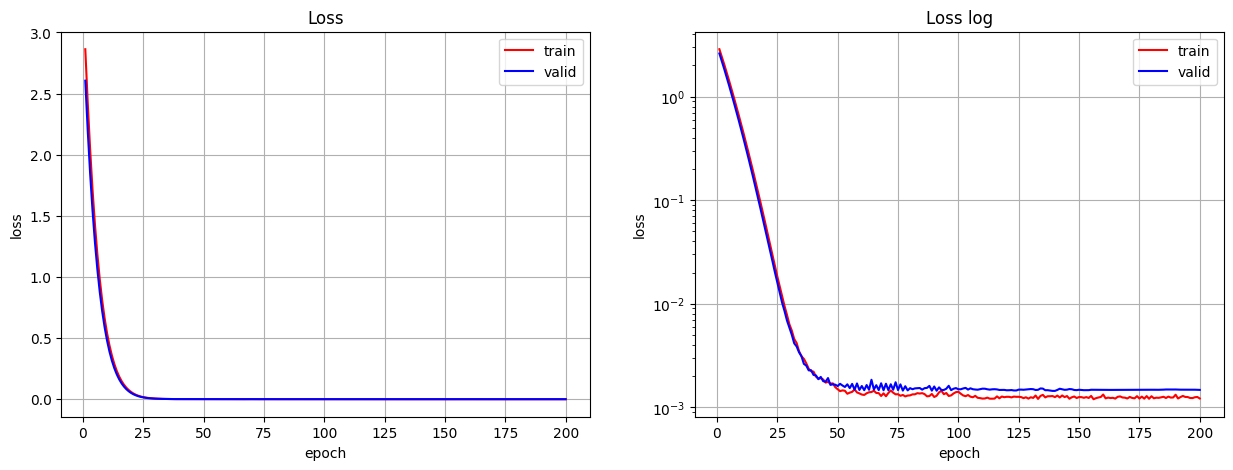

In [24]:
model_dnn_pca_two_components = Sequential((
    Flatten(input_shape=x_train_pca_two_components.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_pca_two_components, 
                         x_train_pca_two_components, y_train,
                         x_val_pca_two_components, y_val, 
                         x_test_pca_two_components, y_test)

### DNN Model with 3 principal components from PCA for all 15 indicators

In [25]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators, n_components=3)
    x.append(indicators.values)

x_pca_three_components = np.array(x)

x_train_pca_three_components = x_pca_three_components[:val_split]
x_val_pca_three_components = x_pca_three_components[val_split:test_split]
x_test_pca_three_components = x_pca_three_components[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 486)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         7,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,251 (32.23 KB)

 Trainable params: 8,251 (32.23 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9403 - val_loss: 2.5284 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4061 - val_loss: 2.0532 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9490 - val_loss: 1.6524 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5653 - val_loss: 1.3195 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2478 - val_loss: 1.0463 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9867 - val_loss: 0.8244 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7761 - val_loss: 0.6456 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6067 - val_loss: 0.5026 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4713 - val_loss: 0.3890 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

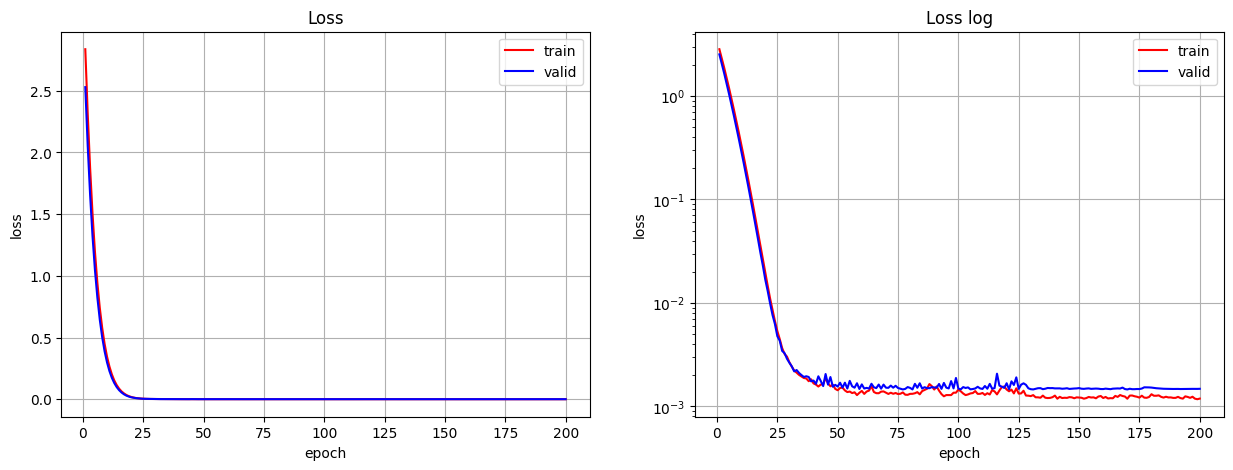

In [26]:
model_dnn_pca_three_components = Sequential((
    Flatten(input_shape=x_train_pca_three_components.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_pca_three_components, 
                         x_train_pca_three_components, y_train,
                         x_val_pca_three_components, y_val, 
                         x_test_pca_three_components, y_test)

## Backtesting

In [27]:
from helper_functions import calculate_returns_for_model, calculate_metrics

In [28]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [29]:
selected_countries = df_countries.columns
days_to_rebalance = dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [30]:
(total_ret_simple_composite_indicator,
 cum_total_ret_simple_composite_indicator) = calculate_returns_for_model(
    model_dnn_simple_composite_indicator, x_test_simple_composite_indicator,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [31]:
(total_ret_manufacturing_pmi, 
 cum_total_ret_manufacturing_pmi) = calculate_returns_for_model(
    model_dnn_manufacturing_pmi, x_test_manufacturing_pmi,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [32]:
(total_ret_separate_indicators, 
 cum_total_ret_separate_indicators) = calculate_returns_for_model(
    model_dnn_separate_indicators, x_test_separate_indicators,
    dates_for_test, df_returns_test, selected_countries)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E705B7D8A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [33]:
(total_ret_separate_all_indicators, 
 cum_total_ret_separate_all_indicators) = calculate_returns_for_model(
    model_dnn_separate_all_indicators, x_test_separate_all_indicators,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [34]:
(total_ret_pca_component, 
 cum_total_ret_pca_component) = calculate_returns_for_model(
    model_dnn_pca_component, x_test_pca_component,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [35]:
(total_ret_pca_component_all, 
 cum_total_ret_pca_component_all) = calculate_returns_for_model(
    model_dnn_pca_component_all, x_test_pca_component_all,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [36]:
(total_ret_pca_two_components, 
 cum_total_ret_pca_two_components) = calculate_returns_for_model(
    model_dnn_pca_two_components, x_test_pca_two_components,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [37]:
(total_ret_pca_three_components, 
 cum_total_ret_pca_three_components) = calculate_returns_for_model(
    model_dnn_pca_three_components, x_test_pca_three_components,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


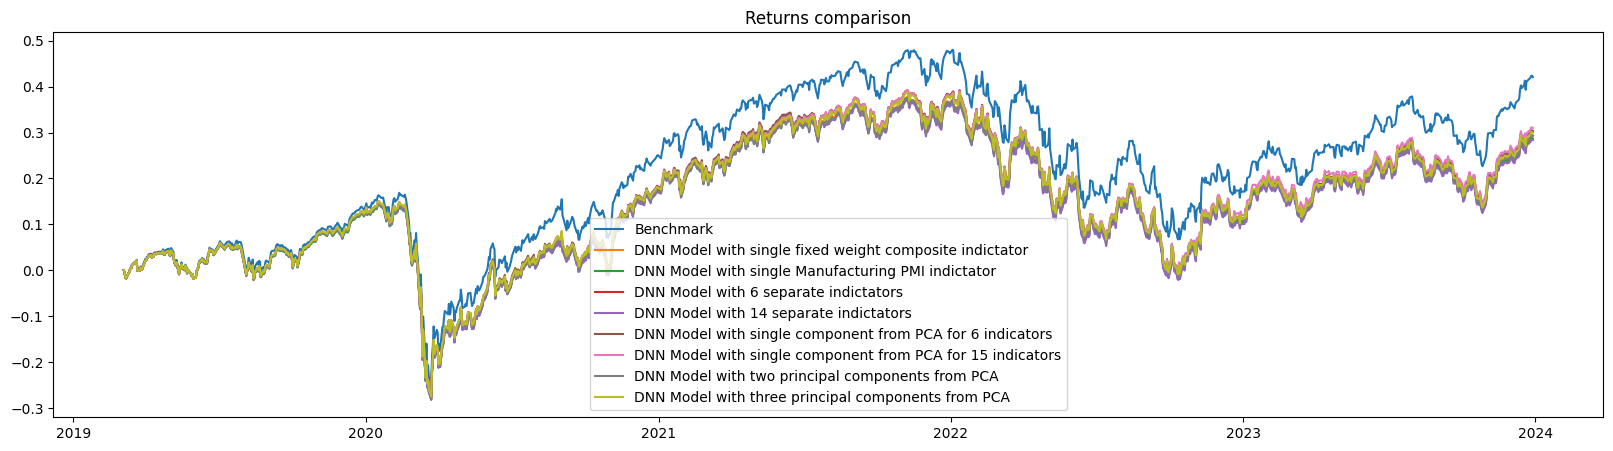

In [38]:
plt.figure(figsize=(20, 5))
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.plot(cum_total_ret_simple_composite_indicator,
         label='DNN Model with single fixed weight composite indictator')
plt.plot(cum_total_ret_manufacturing_pmi,
         label='DNN Model with single Manufacturing PMI indictator')
plt.plot(cum_total_ret_separate_indicators,
         label='DNN Model with 6 separate indictators')
plt.plot(cum_total_ret_separate_all_indicators,
         label='DNN Model with 14 separate indictators')
plt.plot(cum_total_ret_pca_component,
         label='DNN Model with single component from PCA for 6 indicators')
plt.plot(cum_total_ret_pca_component_all,
         label='DNN Model with single component from PCA for 15 indicators')
plt.plot(cum_total_ret_pca_two_components,
         label='DNN Model with two principal components from PCA')
plt.plot(cum_total_ret_pca_three_components,
         label='DNN Model with three principal components from PCA')
plt.legend()
plt.title('Returns comparison')
plt.show()

In [39]:
df_results = pd.DataFrame(columns=['Annual Returns',
                                   'Annual Volatility',
                                   'Annual Sharpe Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_ret_simple_composite_indicator, df_results,
                  'DNN Model with single fixed weight composite indictator')
calculate_metrics(total_ret_manufacturing_pmi, df_results,
                  'DNN Model with single Manufacturing PMI indictator')
calculate_metrics(total_ret_separate_indicators, df_results,
                  'DNN Model with 6 separate indictators')
calculate_metrics(total_ret_separate_all_indicators, df_results,
                  'DNN Model with 14 separate indictators')
calculate_metrics(total_ret_pca_component, df_results,
                  'DNN Model with single component from PCA for 6 indicators')
calculate_metrics(total_ret_pca_component_all, df_results,
                  'DNN Model with single component from PCA for 15 indicators')
calculate_metrics(total_ret_pca_two_components, df_results,
                  'DNN Model with two principal components from PCA')
calculate_metrics(total_ret_pca_three_components, df_results,
                  'DNN Model with three principal components from PCA')


df_results

,Annual Returns,Annual Volatility,Annual Sharpe Ratio
Benchmark,0.076754,0.203326,0.377494
DNN Model with single fixed weight composite indictator,0.054716,0.201388,0.271692
DNN Model with single Manufacturing PMI indictator,0.053764,0.200969,0.267522
DNN Model with 6 separate indictators,0.056431,0.200901,0.280889
DNN Model with 14 separate indictators,0.053144,0.201532,0.263702
DNN Model with single component from PCA for 6 indicators,0.056497,0.201084,0.28096
DNN Model with single component from PCA for 15 indicators,0.057566,0.200514,0.287094
DNN Model with two principal components from PCA,0.054813,0.200332,0.273609
DNN Model with three principal components from PCA,0.055887,0.200951,0.278114
